# Corona prepping using Finnish data regression using a categorical boosting forest algorithm

## Main question: at this point we're interested in one single classification, i.e. __what predicts whether people do maskless contacts with non-householders__

[Research Document](https://docs.google.com/document/d/1iLciHcvVvf8QwFS7wiyNBevpD1B9yDRqMlM4_oCcVcA/edit?usp=sharing)

[Questions codebook](https://docs.google.com/document/d/1YZVCP1UNxnNLAK2kYDfA9Y98leTZYurZD-d8iByhdi0/edit?usp=sharing)

[Method of delivery](https://docs.google.com/document/d/1G1JT9JUJrTK3aaXXuRawYACJaGNxU7mcXL9i-d8eKXY/edit)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from ml_class import (plot_cv_indices,
                      plot_decision_boundary,
                     plot_learning_curve,
                     multi_roc_auc_plot,
                     dict_of_models,
                     RFE_opt_rf,
                     make_confusion_matrix,
                     summary_performance_metrics_classification)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, RepeatedStratifiedKFold, RepeatedKFold
# from sklearn.impute import IterativeImputer

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.feature_selection import RFE, RFECV

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from imblearn.ensemble import BalancedBaggingClassifier

In [4]:
from sklearn.model_selection import KFold

In [5]:
import pingouin as pg

import neuropy_correlation as np_corr

/opt/miniconda3/envs/general/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/miniconda3/envs/general/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
# from sklearn import tree
# import graphviz

In [7]:
from catboost import CatBoostRegressor, Pool

In [8]:
# import xgboost
import shap
shap.initjs()

In [9]:
_ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [10]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [11]:
df = pd.read_csv("data/shield_gjames_21-09-20_prepped.csv").drop("Unnamed: 0", axis=1)

In [12]:
df.head()

id  sampling_weight  demographic_gender demographic_age  \
0   1         2.060959                   2             60+   
1   2         1.784139                   2           40-49   
2   3         1.204000                   1             60+   
3   4         2.232220                   1             60+   
4   5         1.627940                   2           18-29   

   demographic_4_areas  demographic_8_areas  demographic_higher_education  \
0                    2                    7                             0   
1                    1                    1                             1   
2                    1                    2                             1   
3                    2                    6                             0   
4                    1                    3                             0   

   behaviour_indoors_nonhouseholders  behaviour_close_contact  \
0                                  2                        5   
1                                  3                        3   
2                                  4                        4   
3                                  4                        3   
4                                  6                        3   

   behaviour_quarantined  ...  intention_public_transport_recoded  \
0                      2  ...                                   0   
1                      2  ...                                   0   
2                      2  ...                                   0   
3                      2  ...                                   0   
4                      2  ...                                   0   

   intention_indoor_meeting_recoded  intention_restaurant_recoded  \
0                                 0                             0   
1                                 1                             1   
2                                 0                             0   
3                                 2                             0   
4                                 2                             0   

   intention_pa_recoded  intention_composite  \
0                     0                    0   
1                     1                    3   
2                     0                    0   
3                     2                    4   
4                     0                    2   

   behaviour_indoors_nonhouseholders_recoded  behaviour_unmasked_recoded  \
0                                   1.000000                    0.000000   
1                                   0.785714                    0.214286   
2                                   0.500000                    0.214286   
3                                   0.500000                    0.500000   
4                                   0.000000                    0.214286   

   behavior_composite  behavior_composite_recoded  \
0            0.000000                    0.000000   
1            0.168367                    0.841837   
2            0.107143                    0.535714   
3            0.250000                    1.250000   
4            0.000000                    0.000000   

   intention_behavior_composite  
0                      0.000000  
1                      1.920918  
2                      0.267857  
3                      2.625000  
4                      1.000000  

[5 rows x 106 columns]

In [13]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [14]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [15]:
df.shape

(2272, 87)

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [16]:
target = "intention_behavior_composite"

In [17]:
df[target] = (df[target] - 10) * -1

In [18]:
# drop_list = [target, 'intention_store_recoded', 'intention_public_transport_recoded',
#        'intention_indoor_meeting_recoded', 'intention_restaurant_recoded',
#        'intention_pa_recoded', 'intention_composite',
#        'behaviour_indoors_nonhouseholders_recoded',
#        'behaviour_unmasked_recoded', 'behavior_composite',
#        'behavior_composite_recoded', "id", "sampling_weight",
             
#              'behaviour_indoors_nonhouseholders', 'behaviour_close_contact',
#        'behaviour_quarantined', 'behaviour_unmasked',
             
#              'intention_behavior_composite',
#        'intention_indoor_meeting', 'intention_pa',
#        'intention_public_transport', 'intention_restaurant', 'intention_store',
#             ]

# Consider only numerical features
# features_list = df.drop(drop_list, axis=1).columns.tolist()

In [19]:
features_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective").columns.tolist()

## EDA on the target
Check the amount of samples in the target

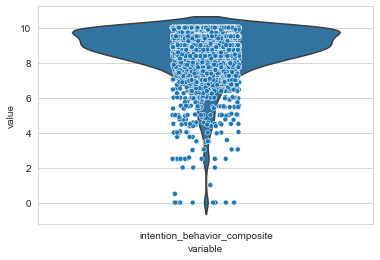

In [20]:
_ = sns.violinplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value"
               )
_ = sns.stripplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value",
                  edgecolor='white',
                  linewidth=0.5
               )

In [21]:
pd.crosstab(df["demographic_gender"], df["demographic_age"])

demographic_age     18-29  30-39  40-49  50-59  60+
demographic_gender                                 
1                     114    169    187    168  337
2                     281    185    229    211  391

In [22]:
target_df = df[target]
target_df.describe().to_frame().T

count      mean       std  min       25%  \
intention_behavior_composite  2272.0  8.582428  1.524704 -0.0  8.017857   

                                   50%  75%   max  
intention_behavior_composite  8.964286  9.5  10.0

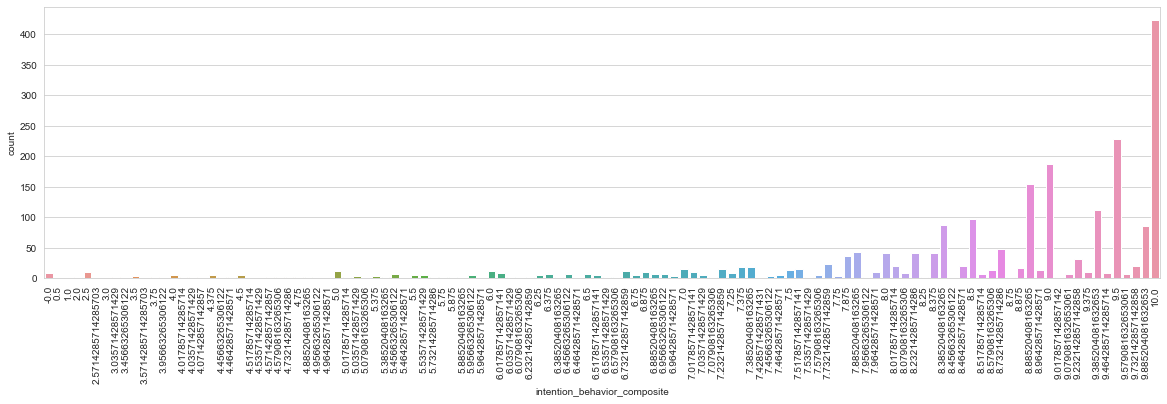

In [23]:
_ = plt.figure(figsize=(20, 5))
_ = sns.countplot(x=target_df)
_ = plt.xticks(rotation=90)

## Force all feature variables to categorical data

In [24]:
df[features_list] = df[features_list].astype("category")

In [25]:
df = (df[["demographic_age", "demographic_higher_education"] + features_list + [target]]
#  .drop(drop_list, axis=1)
#  .assign(target = target_df)
#       .dropna(axis=0)
)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   demographic_age                   2272 non-null   object  
 1   demographic_higher_education      2272 non-null   int64   
 2   automaticity_carry_mask           2272 non-null   category
 3   automaticity_put_on_mask          2272 non-null   category
 4   inst_attitude_protects_self       2272 non-null   category
 5   inst_attitude_protects_others     2272 non-null   category
 6   inst_attitude_sense_of_community  2272 non-null   category
 7   inst_attitude_enough_oxygen       2272 non-null   category
 8   inst_attitude_no_needless_waste   2272 non-null   category
 9   norms_family_friends              2272 non-null   category
 10  norms_risk_groups                 2272 non-null   category
 11  norms_officials                   2272 non-null   catego

In [27]:
grouping_var = target

In [28]:
display(df[grouping_var].value_counts().head().to_frame()), df.shape[0], df[grouping_var].value_counts().head().sum()

intention_behavior_composite
10.000000                           424
9.500000                            228
9.000000                            187
8.885204                            155
9.385204                            112

(None, 2272, 1106)

In [29]:
def naive_catboost_forest_summary(df: pd.DataFrame,
                                 grouping_var: str,
                                 column_list: list,
                                  plot_title: str
                                 ):
    y = df[grouping_var]
    X = df[column_list]

    feature_plot, ax = plt.subplots(figsize=(10,7))
    _ = sns.boxplot(ax=ax, 
                    data=X.apply(lambda x: x.cat.codes), 
                    orient="v", 
#                     palette="Set2"
                   )
    _ = plt.title(f'Feature Distributions {plot_title}')
    _ = plt.setp(ax.get_xticklabels(), rotation=90)
    _ = plt.grid()
    _ = plt.tight_layout()
    _ = plt.show()

    model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

    # train the model
    _ = model.fit(X, y, cat_features=column_list)

    # create dataframe with importances per feature
    feature_importance = pd.Series(dict(zip(column_list, model.feature_importances_.round(2)))) 

    feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

    _ = plt.figure(figsize=(7, 7))
    gini_plot = sns.barplot(data=feature_importance_df#[feature_importance_df["feature_importance"] != 0]
                            , 
                            x="feature_importance", 
                            y="feature")
    _ = plt.title(f'Feature Importance {plot_title}')
    _ = plt.show()

    # model.get_feature_importance(Pool(X, label=y,cat_features=X.columns), type="ShapValues")

    shap_values = model.get_feature_importance(Pool(X, label=y,cat_features=X.columns), type="ShapValues")

    shap_values = shap_values[:,:-1]

#     _ = plt.figure(figsize=(7, 10))
    _ = shap.summary_plot(shap_values, 
                                  X.astype(int), 
                                  feature_names=X.columns, 
                                  max_display=X.shape[1],
                                 show=False,
                         title=plot_title) 
    shap_plot = plt.gca()
    
    tmp_actual = (X
     .melt(value_name='actual_value')
    )

    tmp_shap = (pd.DataFrame(shap_values, columns=column_list)
     .melt(value_name='shap_value')
    )

    shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)

    # train the model
#     _ = model.fit(X[feature_importance_df.head(2).feature.tolist()], y, cat_features=feature_importance_df.head(2).feature.tolist())
    
#     rmse_plot = None
    
    y_pred = model.predict(X)

    df_test = pd.DataFrame({"y_pred": y_pred, grouping_var: y})

    user_ids_first = df_test.head(1).index.tolist()[0]
    user_ids_last = df_test.tail(1).index.tolist()[0]

    _ = plt.figure(figsize=(30,8))
    _ = plt.title(f"Catboost Regressor(fitted set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),4)} | bias Error = {round(np.mean(df_test['y_pred'] - df_test[grouping_var]), 4)} | {plot_title}")
    rmse_plot = plt.stem(df_test.index, df_test['y_pred'] - df_test[grouping_var], use_line_collection=True, linefmt='grey', markerfmt='D')
    _ = plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='+ RMSE', 
                   xmin = user_ids_first, 
                   xmax = user_ids_last
                  ) 
    _ = plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='- RMSE', 
                   xmin = user_ids_first, 
                   xmax = user_ids_last
                  ) 
    _ = plt.xticks(rotation=90, ticks=df_test.index)
    _ = plt.ylabel(f"'Error = y_predicted - {grouping_var}'")
    # _ = plt.ylim([(df_test['y_pred'] - df_test[grouping_var]).min(),
    #               (df_test['y_pred'] - df_test[grouping_var]).max()])
    _ = plt.legend()
    _ = plt.show()
    
    return feature_plot, gini_plot.get_figure(), shap_plot.get_figure(), rmse_plot, feature_importance_df, shap_actual_df

In [30]:
# feature_plot_0, gini_plot_0, shap_plot_0, rmse_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = features_list[2:],
#                                                                                                                                    plot_title="18 - 39"
#                                                                                   )

In [31]:
# feature_plot_0

In [32]:
# features_list[2:]

In [33]:
# df.filter(regex="sdt").columns.tolist()

In [34]:
# %%capture
# feature_plot_0, gini_plot_0, shap_plot_0, dec_bound_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="18 - 39"
#                                                                                   )

# feature_plot_1, gini_plot_1, shap_plot_1, dec_bound_plot_1, feature_importance_df_1, shap_values_1 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="40 - 59"
#                                                                                   )

# feature_plot_2, gini_plot_2, shap_plot_2, dec_bound_plot_2, feature_importance_df_2, shap_values_2 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['60+'])],
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="60+"
#                                                                                   )

# feature_plot_3, gini_plot_3, shap_plot_3, dec_bound_plot_3, feature_importance_df_3, shap_values_3 = naive_catboost_forest_summary(df = df,
#                                                                                    grouping_var = grouping_var,
#                                                                                    column_list = df.filter(regex="sdt").columns.tolist(),
#                                                                                                                                    plot_title="All"
#                                                                                   )

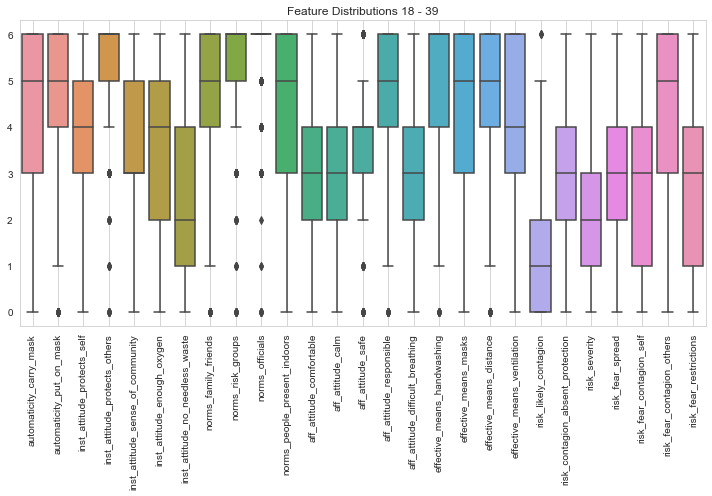

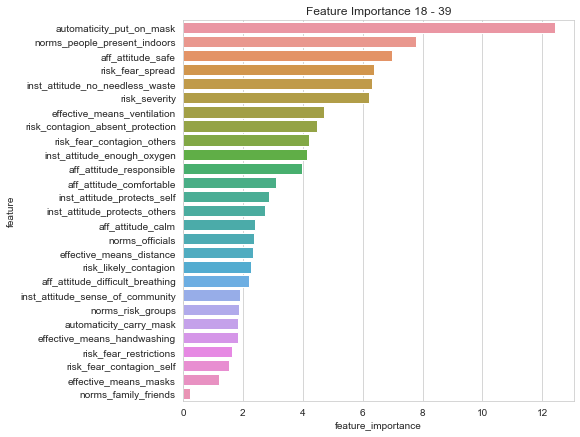

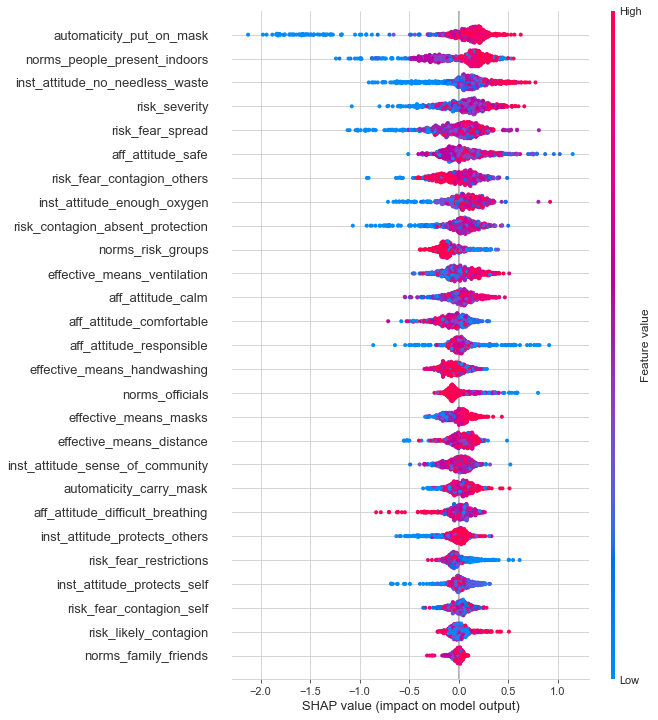

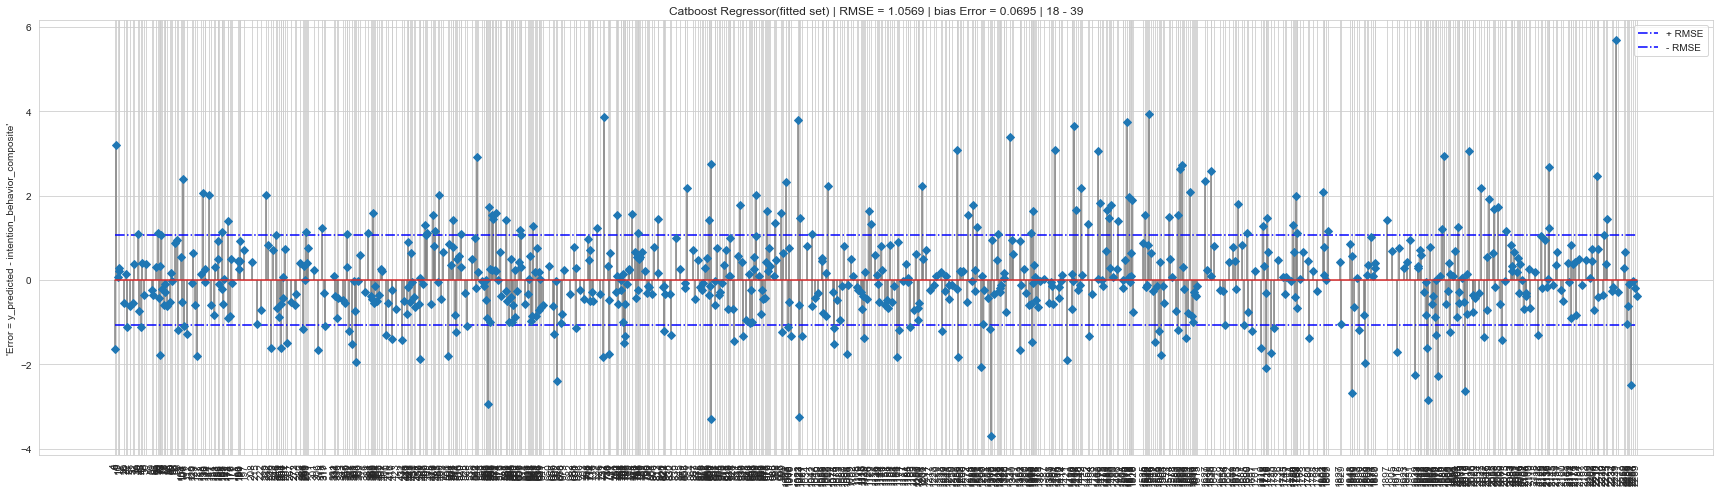

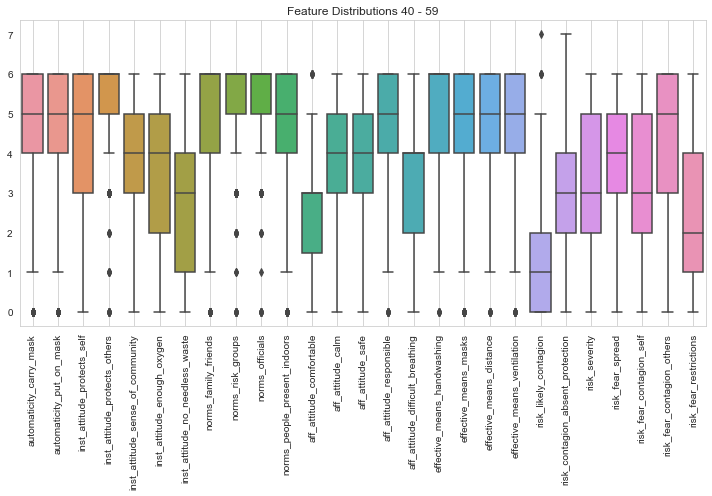

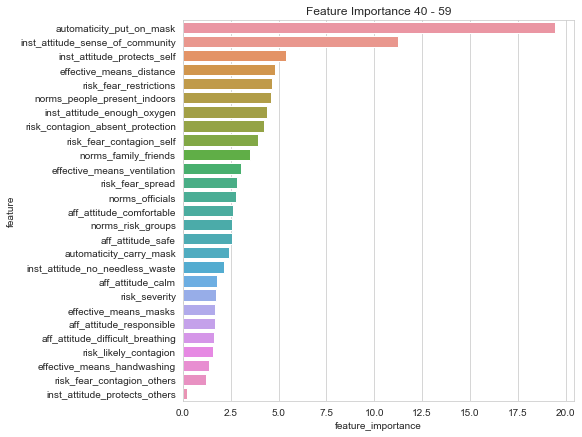

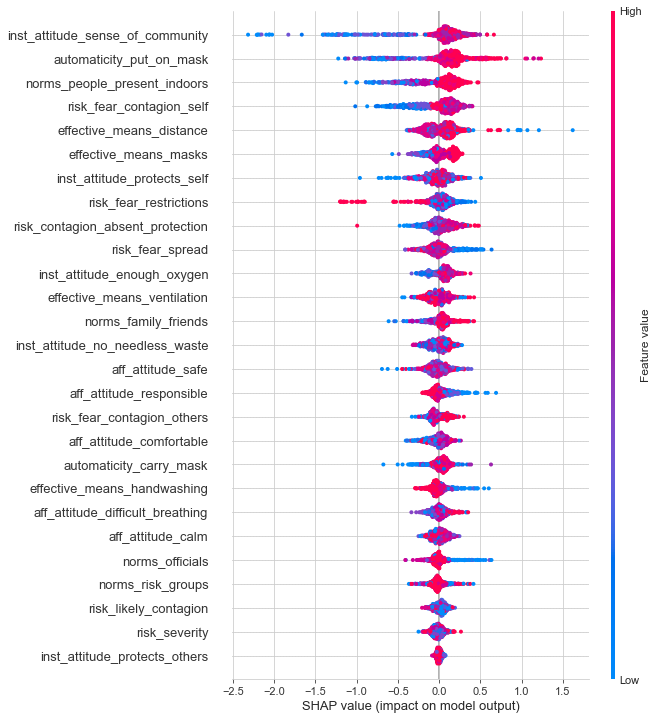

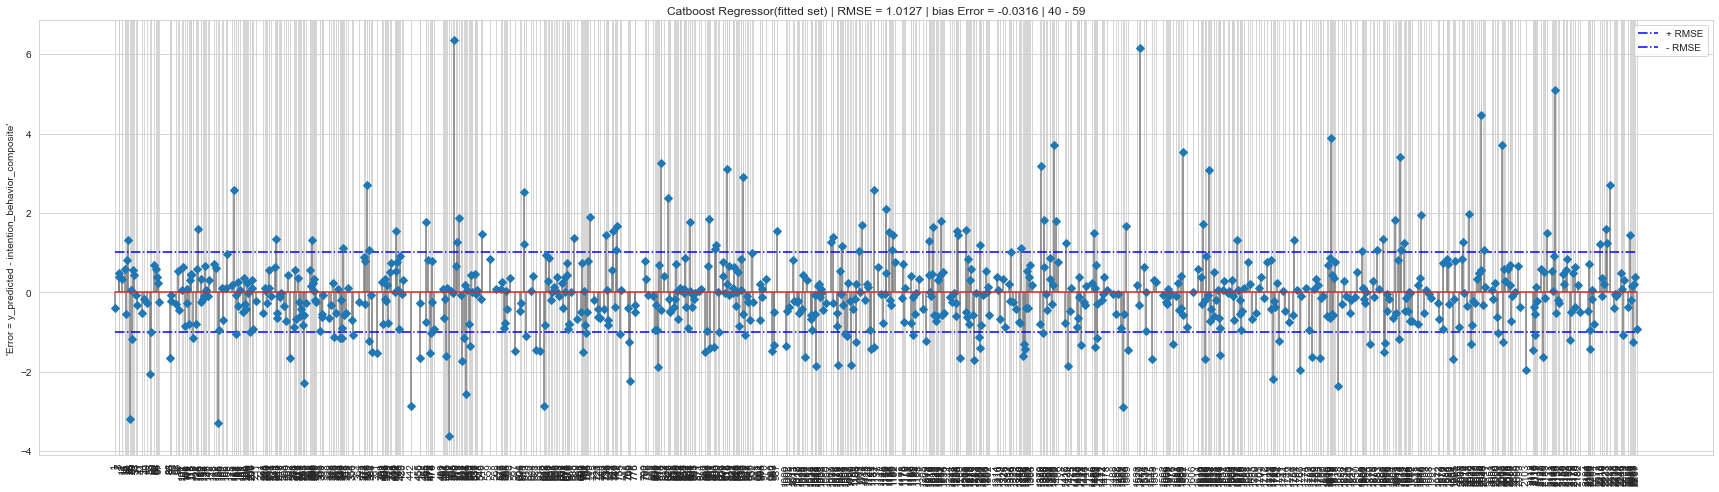

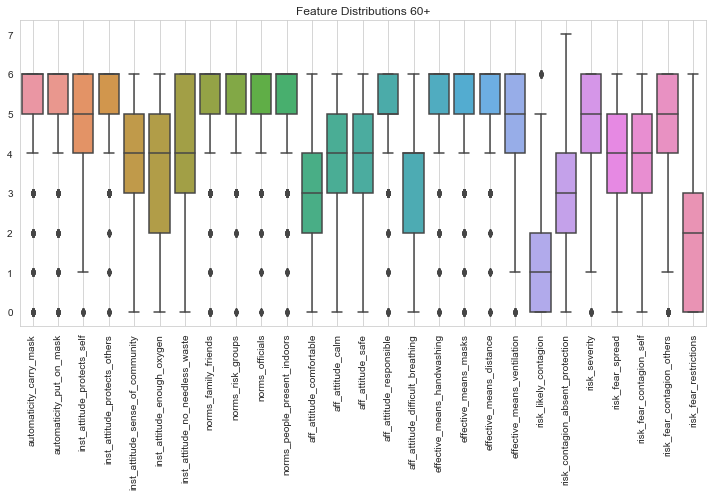

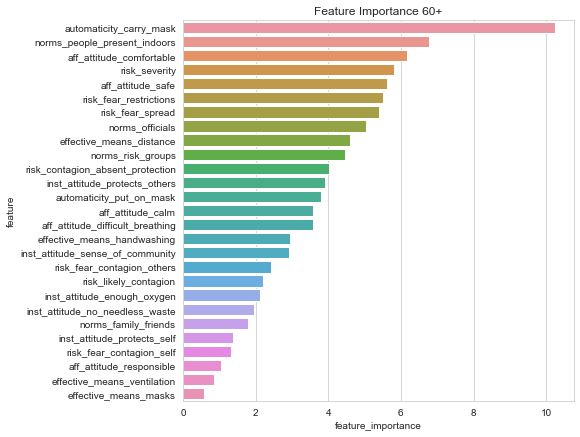

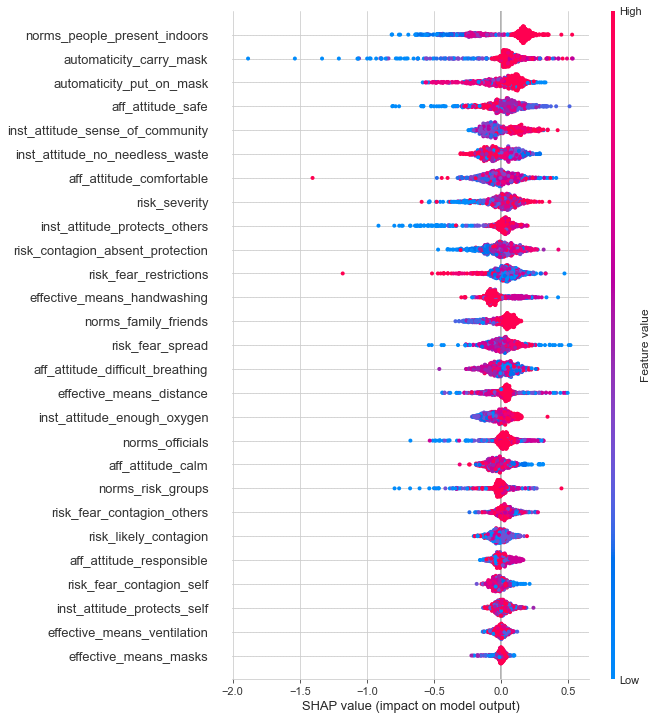

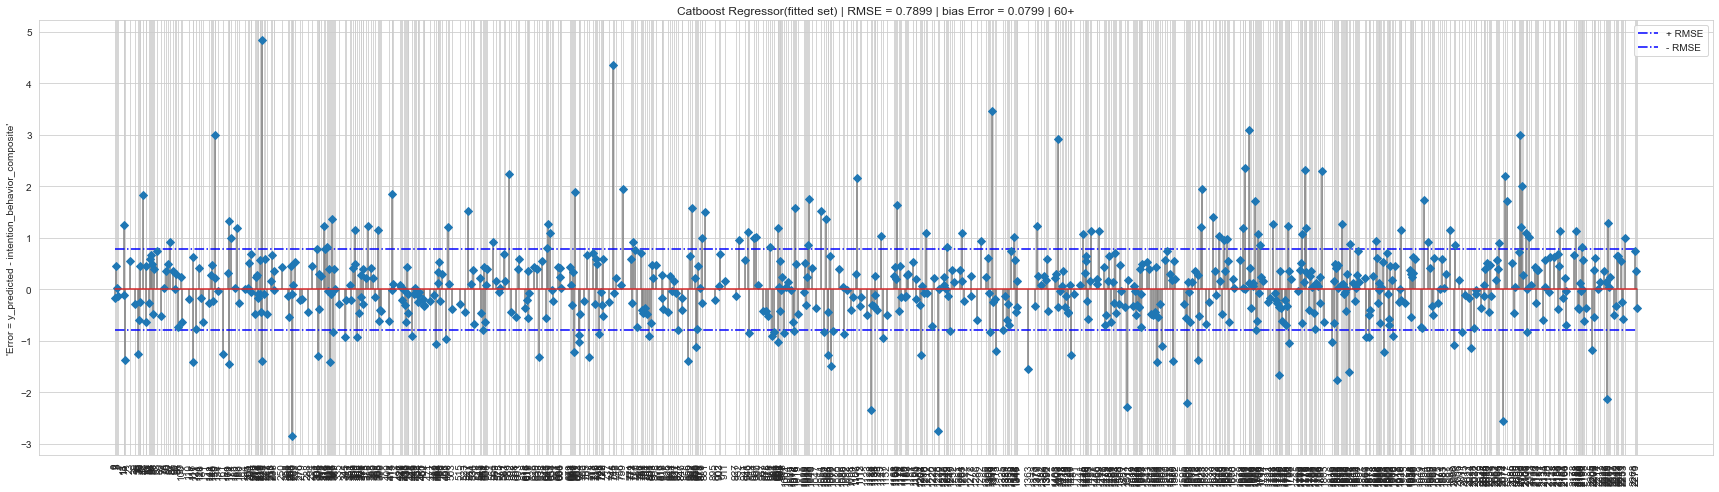

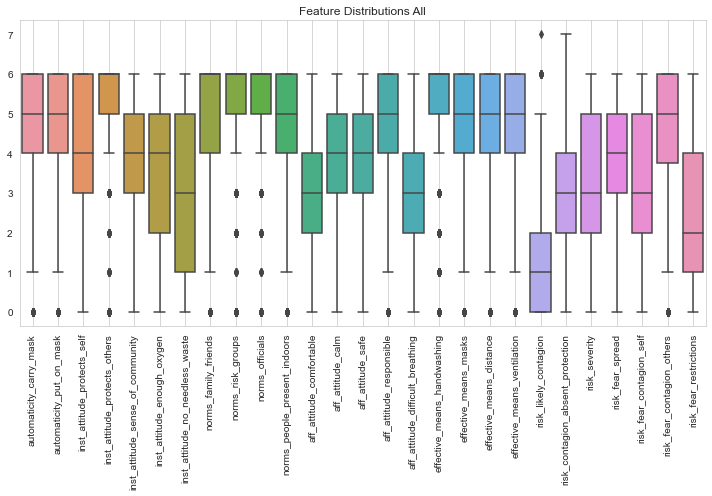

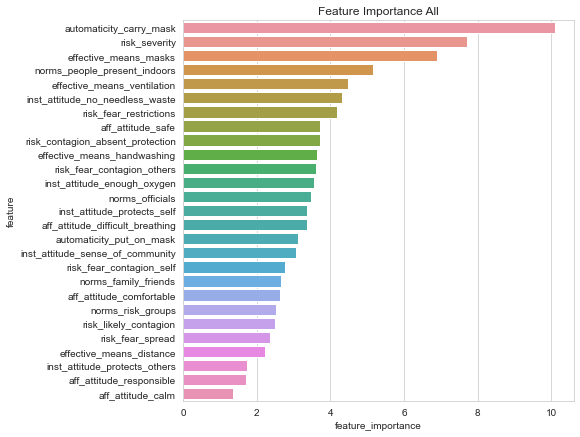

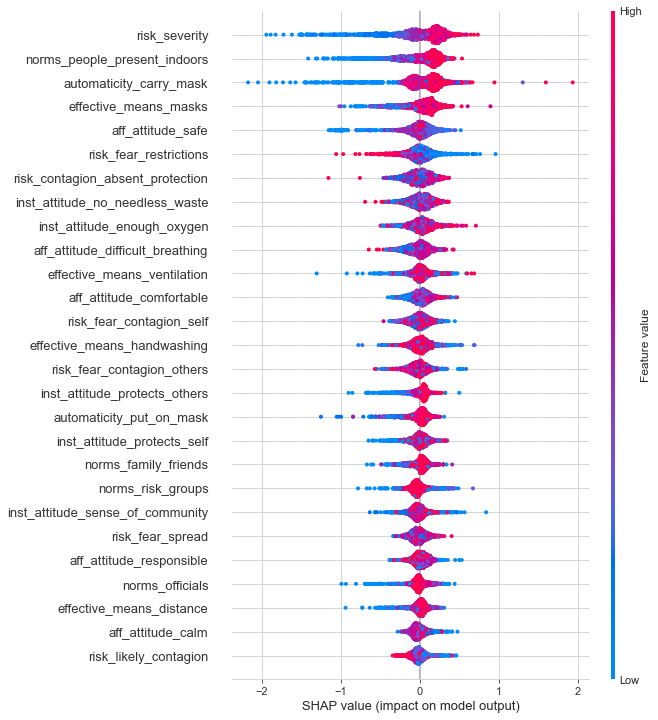

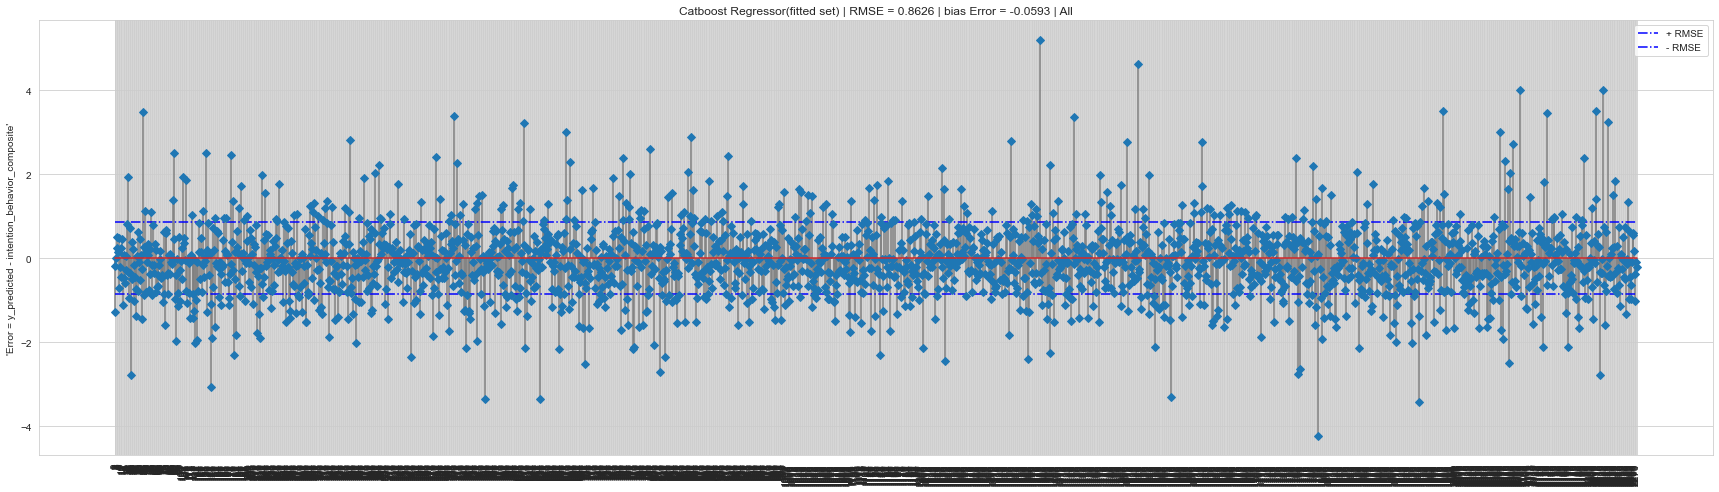

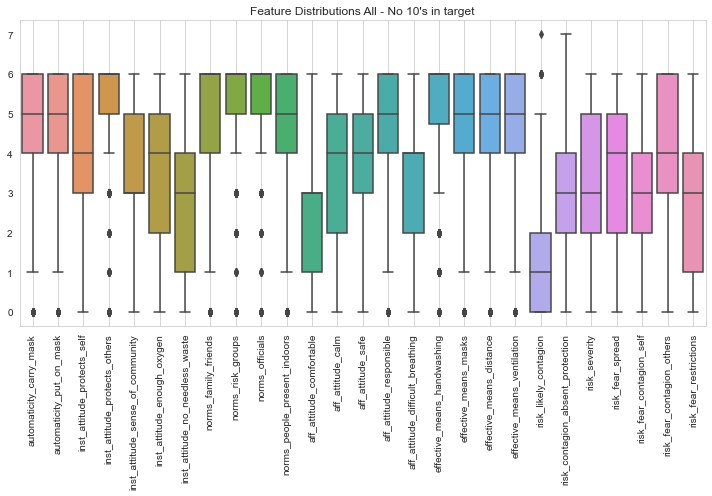

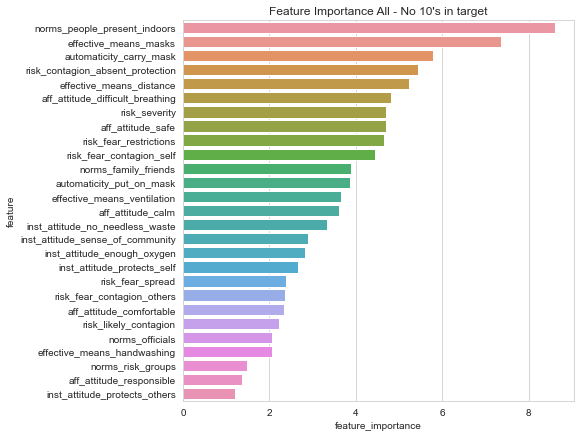

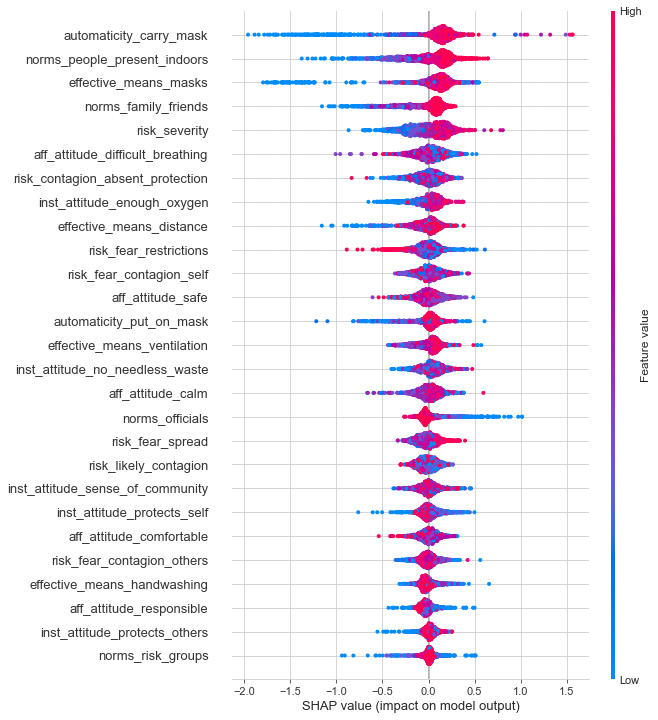

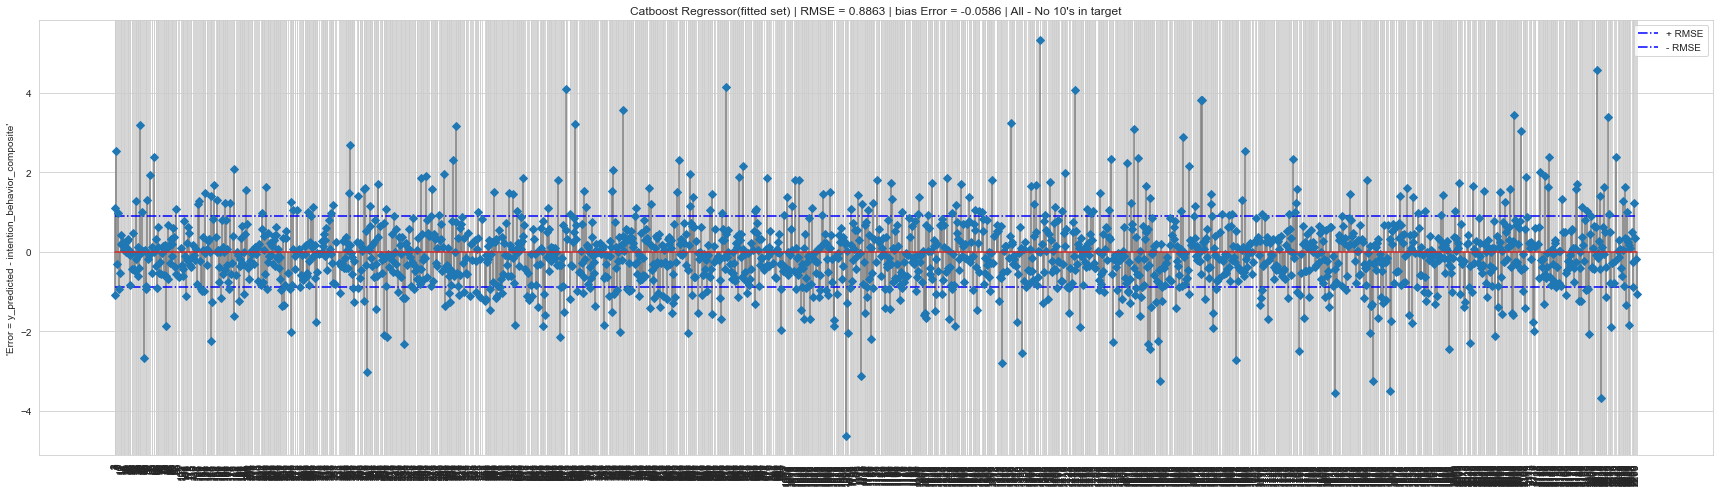

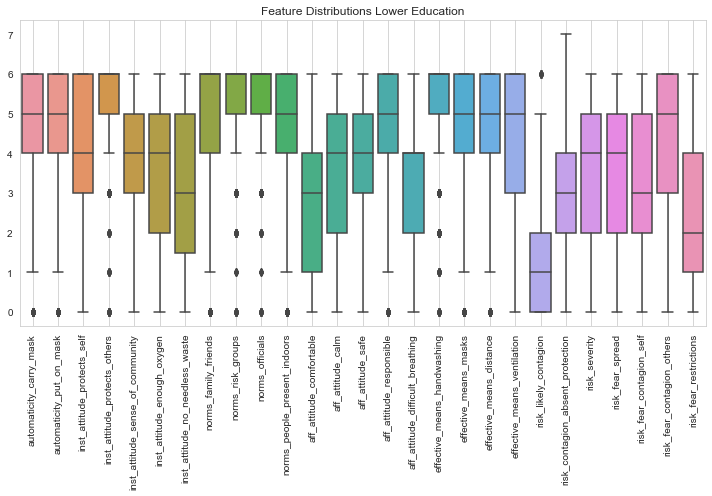

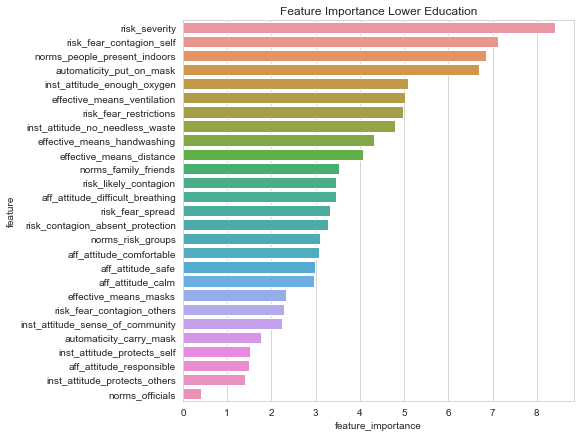

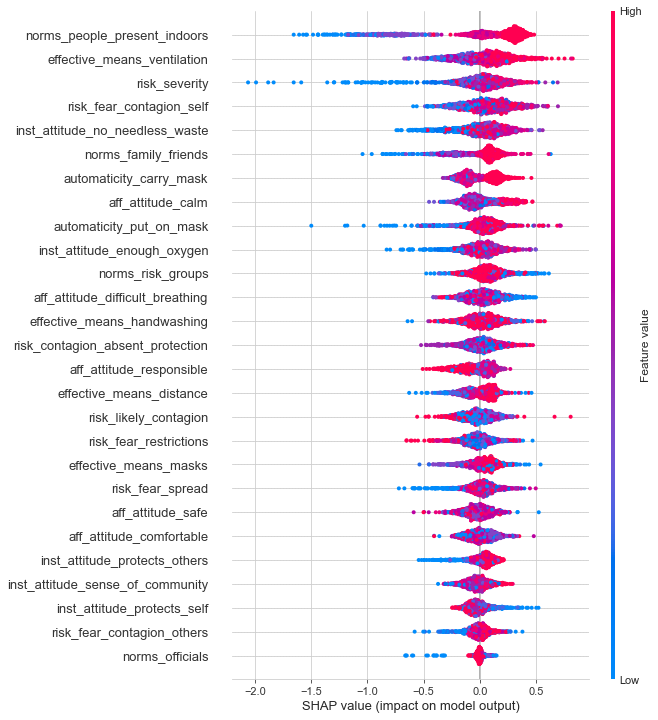

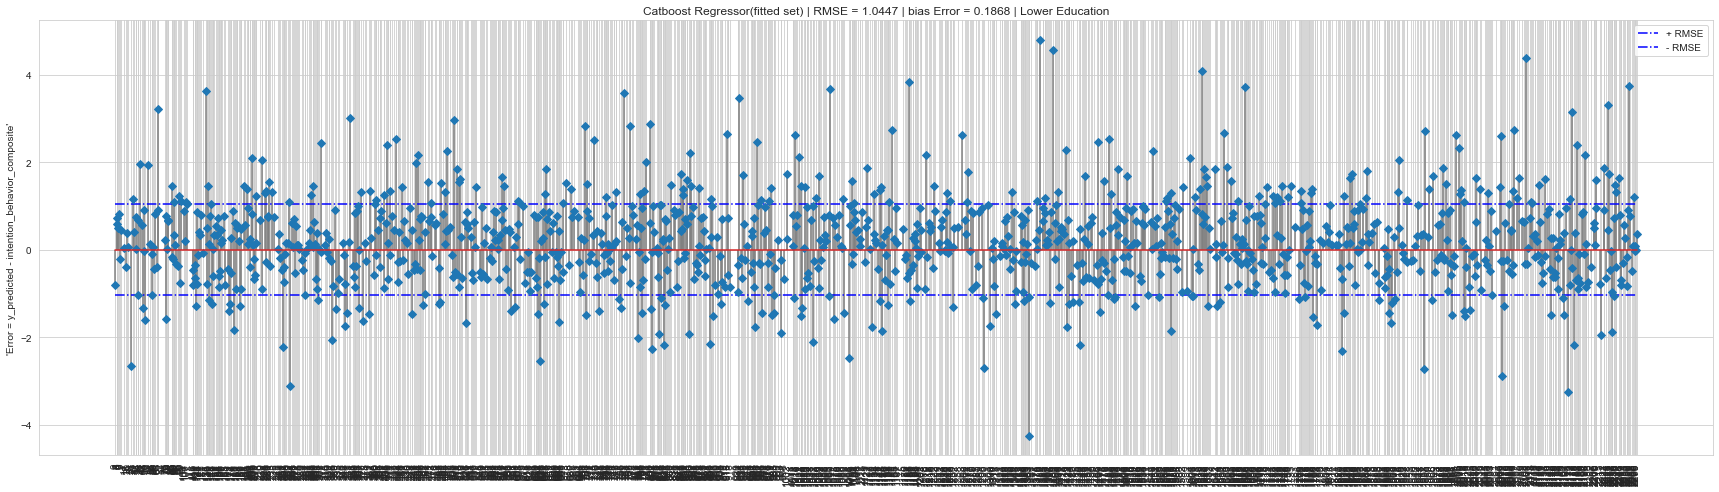

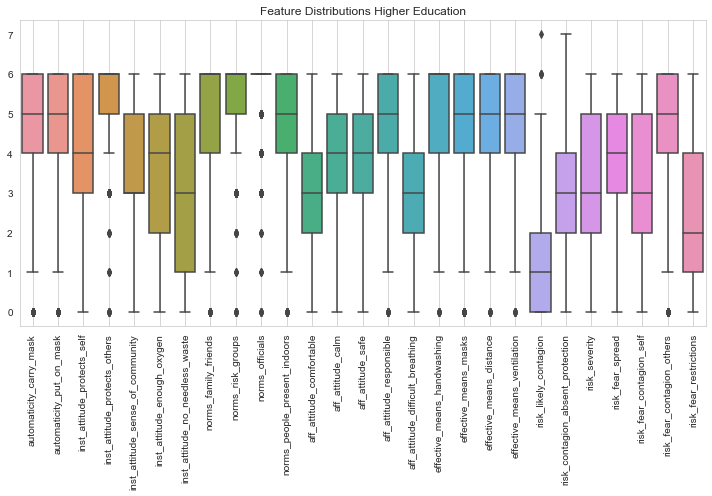

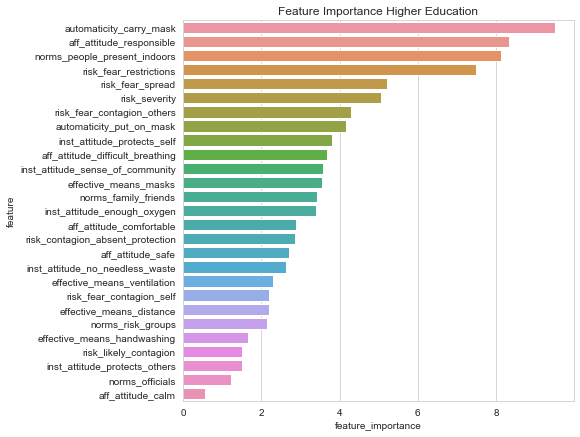

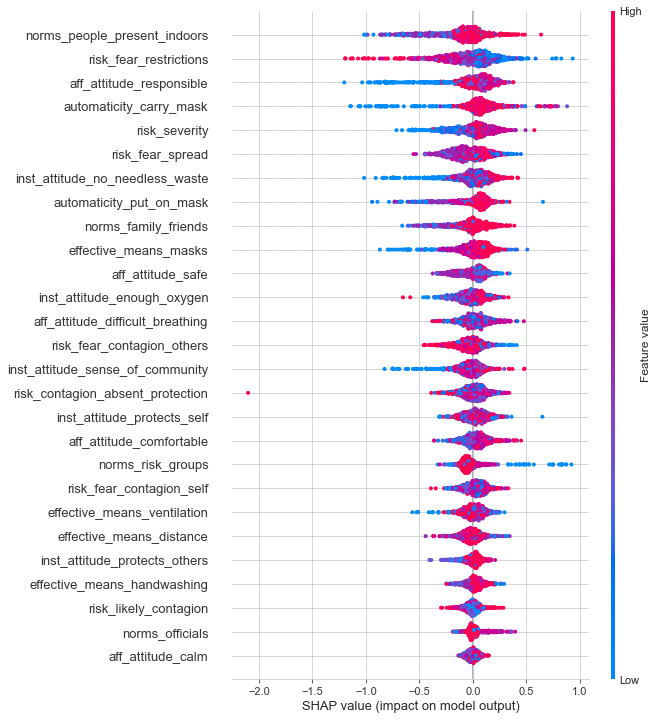

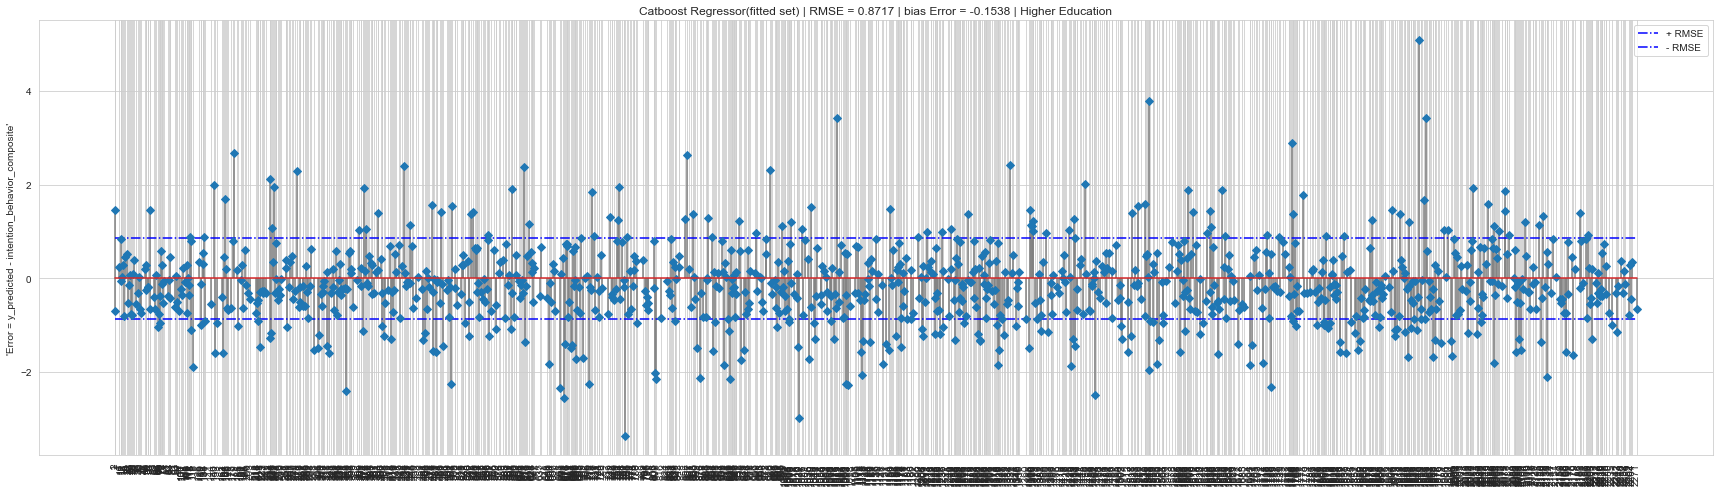

In [35]:
# %%capture
feature_plot_0, gini_plot_0, shap_plot_0, rmse_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="18 - 39"
                                                                                  )

feature_plot_1, gini_plot_1, shap_plot_1, rmse_plot_1, feature_importance_df_1, shap_values_1 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="40 - 59"
                                                                                  )

feature_plot_2, gini_plot_2, shap_plot_2, rmse_plot_2, feature_importance_df_2, shap_values_2 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['60+'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="60+"
                                                                                  )

feature_plot_3, gini_plot_3, shap_plot_3, rmse_plot_3, feature_importance_df_3, shap_values_3 = naive_catboost_forest_summary(df = df,
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="All"
                                                                                  )

feature_plot_4, gini_plot_4, shap_plot_4, rmse_plot_4, feature_importance_df_4, shap_values_4 = naive_catboost_forest_summary(df = df[df[grouping_var]!=10],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="All - No 10's in target"
                                                                                  )

feature_plot_5, gini_plot_5, shap_plot_5, rmse_plot_5, feature_importance_df_5, shap_values_5 = naive_catboost_forest_summary(df = df[df["demographic_higher_education"]==0],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="Lower Education"
                                                                                  )

feature_plot_6, gini_plot_6, shap_plot_6, rmse_plot_6, feature_importance_df_6, shap_values_6 = naive_catboost_forest_summary(df = df[df["demographic_higher_education"]==1],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="Higher Education"
                                                                                  )

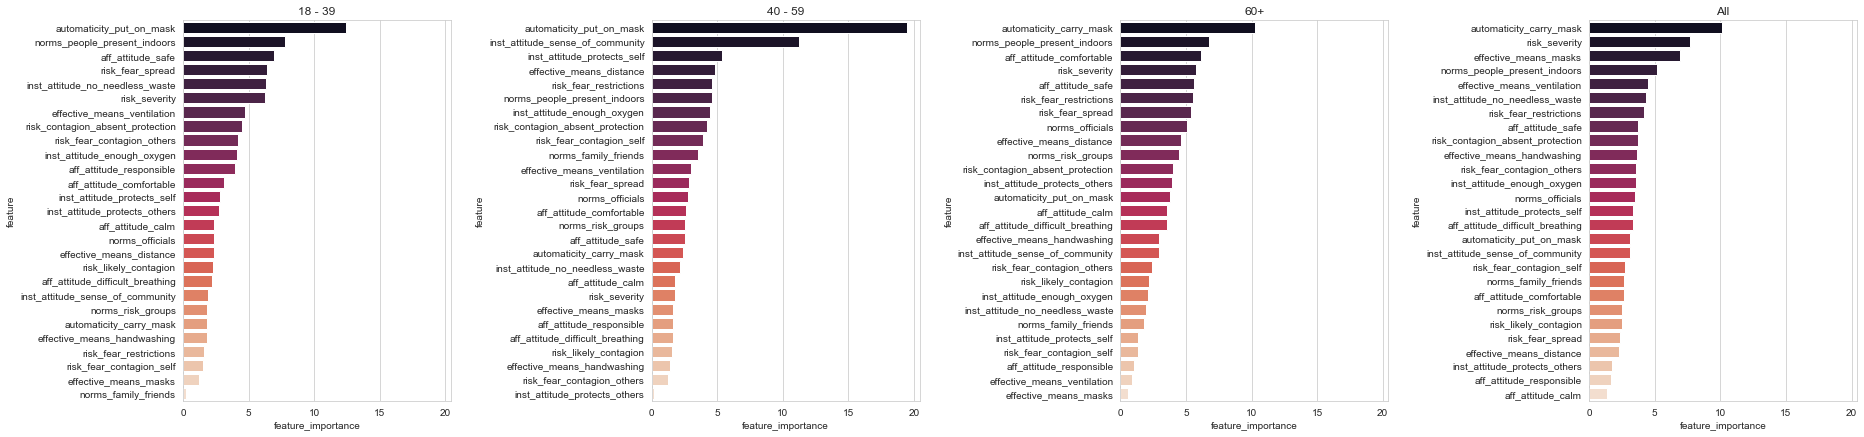

In [36]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 7),
                       gridspec_kw={'wspace': 0.75})
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(fi_dfs_list)):
    fi_df = fi_dfs_list[i]
    _ = sns.barplot(data=fi_df, 
                    x="feature_importance", 
                    y="feature",
                    ax=axs[i],
                    palette="rocket"
                    )
    _ = axs[i].set_title(fi_titles_list[i])
# _ = plt.show()

In [37]:
fig.savefig(f"images/feature_importance_age_groups.png", dpi=400, bbox_inches="tight")

In [38]:
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]
for i in range(0, len(fi_dfs_list)):
    fi_dfs_list[i]["age_group"] = fi_titles_list[i]

In [39]:
# pd.concat(fi_dfs_list, axis=0).groupby("age_group").head()

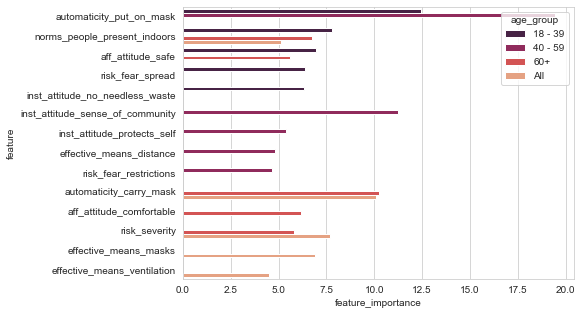

In [40]:
_ = plt.figure(figsize=(7, 5))
_ = sns.barplot(
#     data=pd.concat(fi_dfs_list, axis=0), 
                data=pd.concat(fi_dfs_list, axis=0).groupby("age_group").head(5),
                x="feature_importance", 
                y="feature",
                hue="age_group",
                palette="rocket",
                dodge=True
                )

In [41]:
fis_df = pd.concat(fi_dfs_list, axis=1)

In [42]:
# fis_df.columns = ['feature_young', 'feature_importance_young', 'feature_middle', 'feature_importance_middle',
#        'feature_old', 'feature_importance_old', 'feature_all', 'feature_importance_all']

In [43]:
fis_df.head(5)

feature  feature_importance age_group  \
0         automaticity_put_on_mask               12.42   18 - 39   
1     norms_people_present_indoors                7.77   18 - 39   
2                aff_attitude_safe                6.97   18 - 39   
3                 risk_fear_spread                6.38   18 - 39   
4  inst_attitude_no_needless_waste                6.32   18 - 39   

                            feature  feature_importance age_group  \
0          automaticity_put_on_mask               19.44   40 - 59   
1  inst_attitude_sense_of_community               11.25   40 - 59   
2       inst_attitude_protects_self                5.38   40 - 59   
3          effective_means_distance                4.80   40 - 59   
4            risk_fear_restrictions                4.63   40 - 59   

                        feature  feature_importance age_group  \
0       automaticity_carry_mask               10.24       60+   
1  norms_people_present_indoors                6.76       60+   
2      aff_attitude_comfortable                6.18       60+   
3                 risk_severity                5.80       60+   
4             aff_attitude_safe                5.61       60+   

                        feature  feature_importance age_group  
0       automaticity_carry_mask               10.10       All  
1                 risk_severity                7.71       All  
2         effective_means_masks                6.89       All  
3  norms_people_present_indoors                5.15       All  
4   effective_means_ventilation                4.49       All

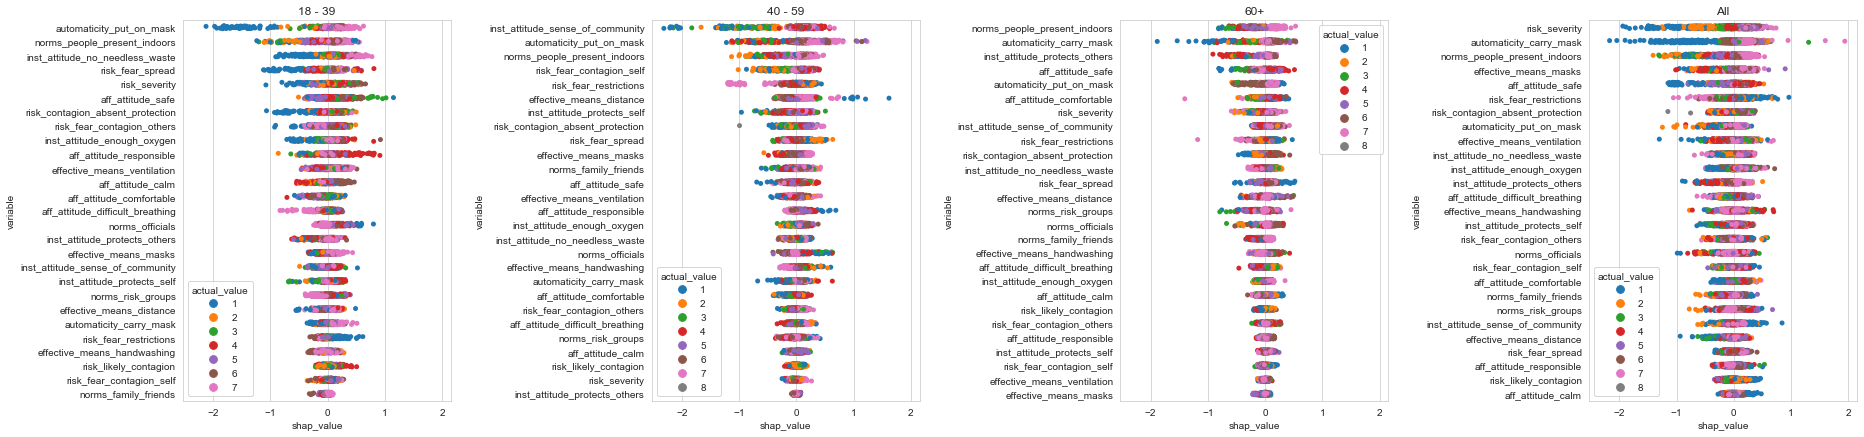

In [44]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 7),
                       gridspec_kw={'wspace': 0.75})
shap_dfs_list = [shap_values_0, shap_values_1, shap_values_2, shap_values_3]
shap_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(shap_dfs_list)):
    shap_df = shap_dfs_list[i]
    var_order = shap_df.groupby("variable").var().sort_values(by = "shap_value", ascending = False).index.tolist()
    _ = sns.stripplot(data=shap_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
                  order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
    _ = axs[i].set_title(shap_titles_list[i])
# _ = plt.show()

In [45]:
# shap_dfs_list = [shap_values_0, shap_values_1, shap_values_2, shap_values_3, shap_values_5, shap_values_6]
# shap_titles_list = ["18 - 39", "40 - 59", "60+", "All", "Lower_Education", "Higher_Education"]

# for i in range(0, len(shap_dfs_list)):
#     tmp_shap_df = shap_dfs_list[i]
#     tmp_shap_df.to_csv(f"figure_data/{shap_titles_list[i]}_shap_real_values.csv")

In [46]:
fig.savefig(f"images/shap_values_all_age_groups.png", dpi=400, bbox_inches="tight")

In [47]:
# shap_plot_3.suptitle("My title")
plot_title = "18 - 39"
shap_plot_0.suptitle(plot_title, y=0.89)
shap_plot_0.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "40 - 59"
shap_plot_1.suptitle(plot_title, y=0.89)
shap_plot_1.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "60+"
shap_plot_2.suptitle(plot_title, y=0.89)
shap_plot_2.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")
plot_title = "All"
shap_plot_3.suptitle(plot_title, y=0.89)
shap_plot_3.savefig(f"images/shap_values_{plot_title}.png", dpi=400, bbox_inches="tight")

In [48]:
# dec_bound_plot_0

In [49]:
# clf = CatBoostClassifier(iterations=500,
#                            depth=None,
#                            learning_rate=1,
#                            loss_function='Logloss',
#                            verbose=False)

In [50]:
# feature_importance_df_0.head(5).feature.tolist()

In [51]:
# tmp_df = df[df["demographic_age"].isin(['18-29', '30-39'])].reset_index()
# tmp_df = df[df["demographic_age"].isin(['40-49', '50-59'])].reset_index()
# tmp_df = df[df["demographic_age"].isin(['60+'])].reset_index()
tmp_df = df.reset_index(drop=True)

# X = tmp_df[feature_importance_df_0.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_1.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_2.head(5).feature.tolist()]
# X = tmp_df[feature_importance_df_3.head(5).feature.tolist()]

X = tmp_df[features_list[2:]]

# X = tmp_df[df.filter(regex="sdt").columns.tolist()]

y = tmp_df[grouping_var]

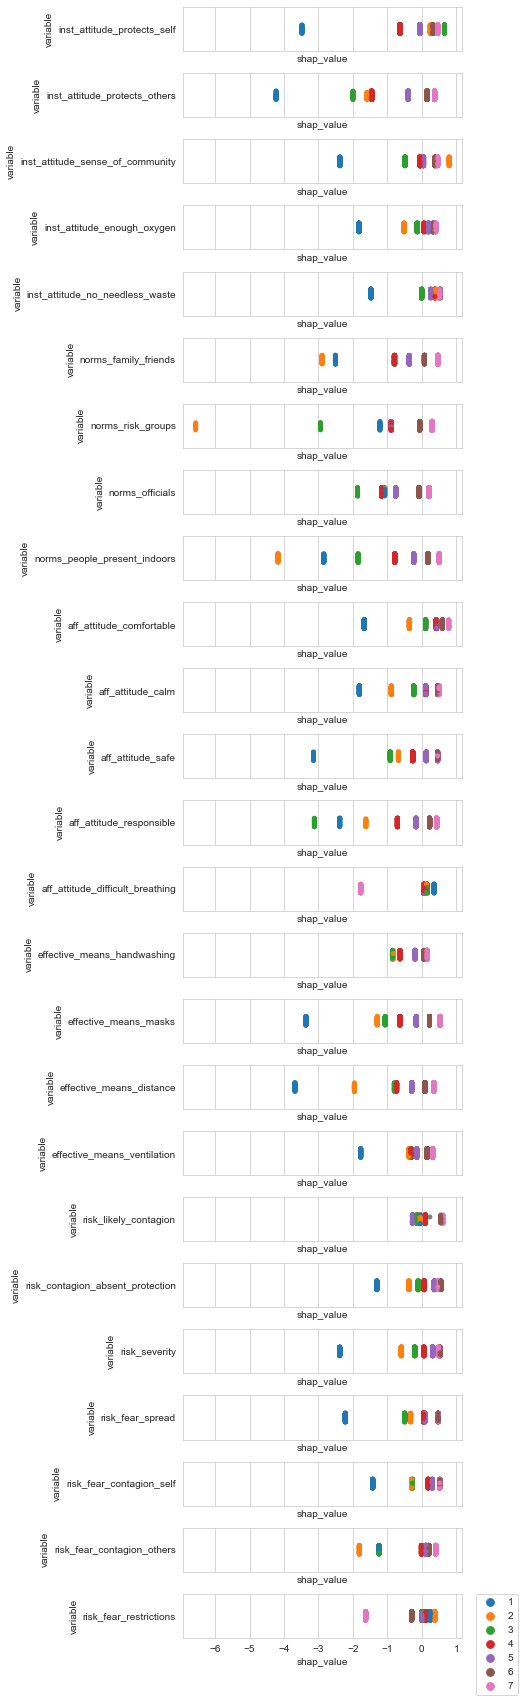

In [52]:
fig, axs = plt.subplots(nrows=X.shape[1],
                 ncols=1,
                 sharex=True,
                 sharey=False,
                       figsize=(5, 30),
                       gridspec_kw={#'wspace': 0.75
                           'hspace': 0.5
                                   }
                       )

for i in range(0, X.shape[1]):

    feature = X.columns.tolist()[i]
    
    model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

    # train the model
    _ = model.fit(X[[feature]], y, cat_features=[feature]
                 )

    shap_values = model.get_feature_importance(Pool(X[[feature]], label=y,cat_features=[feature]), type="ShapValues")

    shap_values = shap_values[:,:-1]

    tmp_actual = (X[[feature]]
     .melt(value_name='actual_value')
    )

    tmp_shap = (pd.DataFrame(shap_values, columns=[feature])
     .melt(value_name='shap_value')
    )

    shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)
    
    if i == X.shape[1]-1:
        strip = sns.stripplot(data=shap_actual_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
#                   order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
        strip.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        strip = sns.stripplot(data=shap_actual_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
#                   order=var_order,
                    ax=axs[i],
#                     palette="rocket"
                    )
        strip.legend_.remove()

In [53]:
_ = fig.savefig(f"images/shap_values_ALL_analysis_seperate_per_feature.png", dpi=400, bbox_inches="tight")

In [54]:
accuracies_list = list()
all_pred_test_df = pd.DataFrame()
all_cors_df = pd.DataFrame()
# kfold = KFold(n_splits=50, shuffle=True, random_state=42)
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
fold_number = 1

model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
#     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = model.fit(X = train_X, 
                y = train_y,
               cat_features=X.columns)
    
    pred_y = model.predict(test_X)
    _ = accuracies_list.append(np.sqrt(mean_squared_error(test_y, pred_y)))
    
    pred_test_df = pd.DataFrame({grouping_var: test_y,
                 "predict": pred_y,
                                "fold_number": f"fold_{fold_number}"})
    
    all_pred_test_df = pd.concat([all_pred_test_df, 
                             pred_test_df
                            ])

    corr_df = pg.corr(x=pred_test_df[grouping_var], 
            y=pred_test_df["predict"], 
            tail='two-sided', 
            method='spearman', 
    #         **kwargs
           )
    
    all_cors_df = pd.concat([all_cors_df, 
                             corr_df.assign(fold_number=f"fold_{fold_number}")
                            ])
    
    fold_number += 1

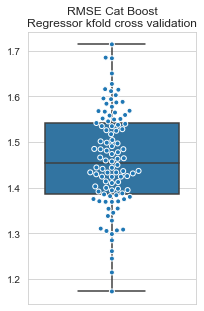

In [55]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("RMSE Cat Boost\nRegressor kfold cross validation")

In [56]:
pd.DataFrame(accuracies_list).describe().T

count      mean       std       min       25%      50%       75%       max
0  100.0  1.460889  0.107116  1.172973  1.387053  1.45378  1.542548  1.713833

In [57]:
# pd.DataFrame(model.predict(X)).head()

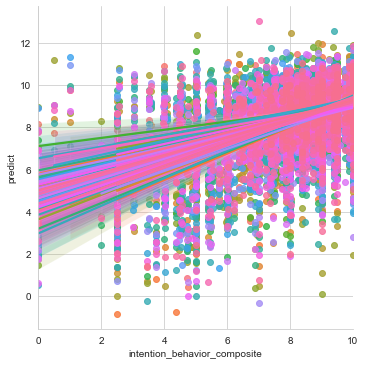

In [58]:
_ = sns.lmplot(data=all_pred_test_df, 
               x=grouping_var, 
               y="predict", 
               hue="fold_number",
              legend=False)

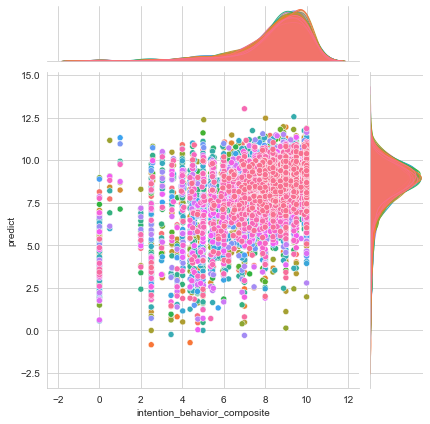

In [59]:
ax = sns.jointplot(data=all_pred_test_df, 
                  x=grouping_var, 
                  y="predict", 
                  hue="fold_number",
#                   kind="reg",
                   legend=False
                 )
# _ = ax._legend.remove()

In [60]:
all_cors_df.describe()

n           r         p-val       power
count  100.000000  100.000000  1.000000e+02  100.000000
mean   227.200000    0.337624  1.474281e-04    0.989853
std      0.402015    0.063481  8.058543e-04    0.031872
min    227.000000    0.177255  1.944096e-15    0.766244
25%    227.000000    0.293919  4.683890e-09    0.995085
50%    227.000000    0.338370  1.743040e-07    0.999554
75%    227.000000    0.376328  6.681203e-06    0.999965
max    228.000000    0.495058  7.426213e-03    1.000000

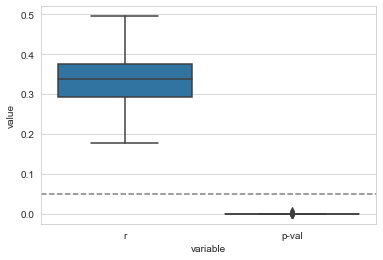

In [61]:
_ = sns.boxplot(data=all_cors_df[["r", "p-val"]].melt(),
                x="variable", y="value")
_ = plt.axhline(y=0.05, c="grey", ls="--")

In [62]:
# summary, fig = np_corr.correlations_as_sample_increases(all_pred_test_df, 
#                   feature1=grouping_var, 
#                   feature2="predict",
#                                                        plot=False)

In [63]:
# _ = plt.figure(figsize=(10,5))
# ax = sns.lineplot(data = summary,
#                 x="N",
#                 y="r-value",
# #                 hue="user_id"
#                   color="blue",
#                 )
# ax2 = plt.twinx()
# _ = sns.lineplot(data = summary,
#                 x="N",
#                 y="p-value",
# #                 hue="user_id",
#                  color="orange",
#                  ax=ax2
#                 )
# _ = plt.axhline(0.05, c="gray", ls="--")
# # _ = plt.axhline(0.0, c="gray")

# ax2.spines['left'].set_color("blue")
# ax2.spines['left'].set_linewidth(2)
# ax2.spines['bottom'].set_color("blue")
# ax2.spines['bottom'].set_linewidth(2)
# ax2.spines['right'].set_color("orange")
# ax2.spines['right'].set_linewidth(2)
# ax2.spines['top'].set_color("orange")
# ax2.spines['top'].set_linewidth(2)

# ax.yaxis.set_ticks_position('none') 
# ax2.yaxis.set_ticks_position('none') 

# _ = plt.title("Correlation between real and predicted mask obedience")
# # _ = plt.savefig(f"images/correlation_predict_vs_real.png", dpi=400, format="png")

In [64]:
all_cors_as_N_increases_df = pd.DataFrame()
for fold_number in all_pred_test_df.fold_number.unique().tolist():
    summary, fig = np_corr.correlations_as_sample_increases(all_pred_test_df[all_pred_test_df["fold_number"]==fold_number], 
                  feature1=grouping_var, 
                  feature2="predict",
                                                            method='spearman',
                                                           plot=False)

    all_cors_as_N_increases_df = pd.concat([all_cors_as_N_increases_df, 
                                            summary.assign(fold_number=f"fold_{fold_number}")])

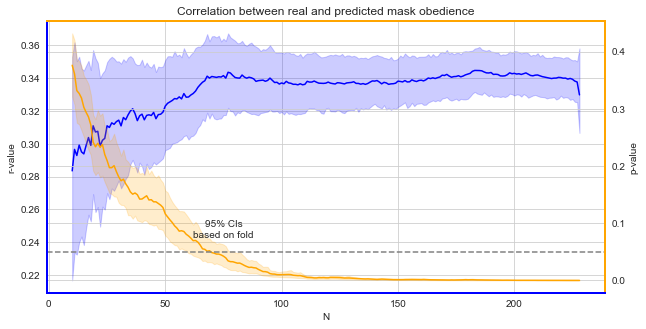

In [65]:
_ = plt.figure(figsize=(10,5))
ax = sns.lineplot(data = all_cors_as_N_increases_df,
                x="N",
                y="r-value",
#                 hue="user_id"
                  color="blue",
                )
ax2 = plt.twinx()
_ = sns.lineplot(data = all_cors_as_N_increases_df,
                x="N",
                y="p-value",
#                 hue="user_id",
                 color="orange",
                 ax=ax2
                )
_ = plt.axhline(0.05, c="gray", ls="--")
# _ = plt.axhline(0.0, c="gray")

ax2.spines['left'].set_color("blue")
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_color("blue")
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['right'].set_color("orange")
ax2.spines['right'].set_linewidth(2)
ax2.spines['top'].set_color("orange")
ax2.spines['top'].set_linewidth(2)

ax.yaxis.set_ticks_position('none') 
ax2.yaxis.set_ticks_position('none') 

_ = plt.title("Correlation between real and predicted mask obedience")

_ = plt.annotate(xy=(75, 0.075), text="95% CIs\nbased on fold", ha="center")

# _ = plt.xlim((0, 100))
# _ = plt.ylim((0, 100))

_ = plt.savefig(f"images/correlation_predict_vs_real_CIs_per_fold.png", dpi=400, format="png")